In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.linear_model import LinearRegression

## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

## viz
import matplotlib.pyplot as plt
import seaborn as sns

## model
import statsmodels.api as sm
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [7]:
PATH = "../Dados/Armarios/"
FILE = "consumo_macroregioes.txt"

In [8]:
consumo_macroregioes = pd.read_csv(PATH + FILE, sep = '\t')
consumo_macroregioes['mes'] = consumo_macroregioes['mes'].astype('string')
consumo_macroregioes['mes'] = consumo_macroregioes['mes'].apply(lambda x: pd.to_datetime(str(x) + '01'))
consumo_macroregioes.dtypes

contagem                int64
mes            datetime64[ns]
macroregiao            object
consumo               float64
custo                 float64
dtype: object

In [226]:
consumo_macroregioes

,contagem,custo,consumo,mes,macroregiao
0,442,480234.46,651819.30,2017-01-01,NE
1,1621,1736961.80,2578865.00,2017-01-01,S
2,717,679924.46,979926.39,2017-01-01,CO
3,1534,1370699.86,1975685.45,2017-01-01,SE
4,726,652974.70,933461.28,2017-02-01,CO
...,...,...,...,...,...
318,375,204373.67,241066.03,2022-05-01,CO
319,1,2063.19,1776.00,2022-05-01,N
320,497,656417.78,571878.00,2022-05-01,NE
321,1563,1322533.63,1542652.84,2022-05-01,S


In [13]:
df = consumo_macroregioes[consumo_macroregioes.macroregiao=='SE'][['mes', 'consumo']].groupby(by='mes').sum('consumo').reset_index(drop=False).copy()
#df = df = consumo_macroregioes[['mes', 'consumo']].groupby(by='mes').sum('consumo').reset_index(drop=False).copy()
df.columns = ['ds', 'y']
df

,ds,y
0,2017-01-01,1975685.45
1,2017-02-01,1918435.64
2,2017-03-01,2093317.00
3,2017-04-01,1792771.74
4,2017-05-01,2132525.30
...,...,...
60,2022-01-01,1445668.92
61,2022-02-01,1389495.49
62,2022-03-01,1464993.20
63,2022-04-01,1371781.80


In [10]:
df.reset_index(drop=True, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      65 non-null     datetime64[ns]
 1   y       65 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [229]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
y,65.0,1.904961e+06,248654.008156,1352877.6,1766627.32,2000941.4,2095294.8,2182932.39


<AxesSubplot:>

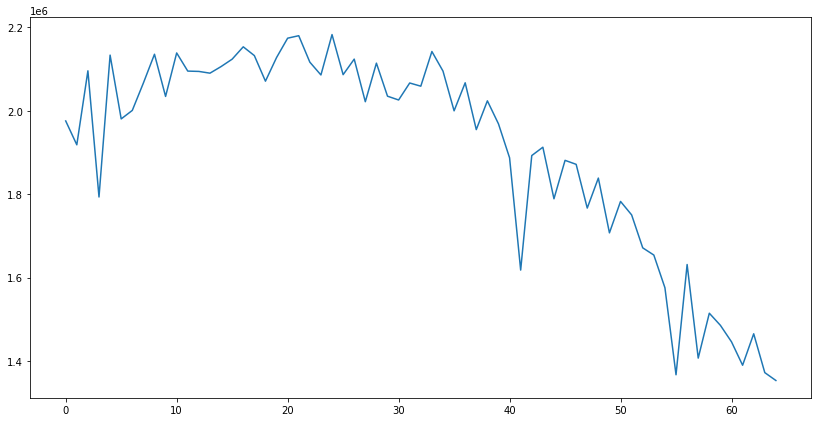

In [230]:
df['y'].plot(figsize=(14, 7))

In [231]:
df_plot = df[['ds', 'y']]
df_plot['mm'] = df_plot['y'].rolling(window=6).mean()

df_plot.head(10)

,ds,y,mm
0,2017-01-01,1975685.45,NaN
1,2017-02-01,1918435.64,NaN
2,2017-03-01,2095963.00,NaN
3,2017-04-01,1793219.74,NaN
4,2017-05-01,2133632.30,NaN
5,2017-06-01,1980589.30,1982920.905
6,2017-07-01,2000941.40,1987130.230
7,2017-08-01,2066683.40,2011838.190
8,2017-09-01,2135728.90,2018465.840
9,2017-10-01,2034511.00,2058681.050


<AxesSubplot:>

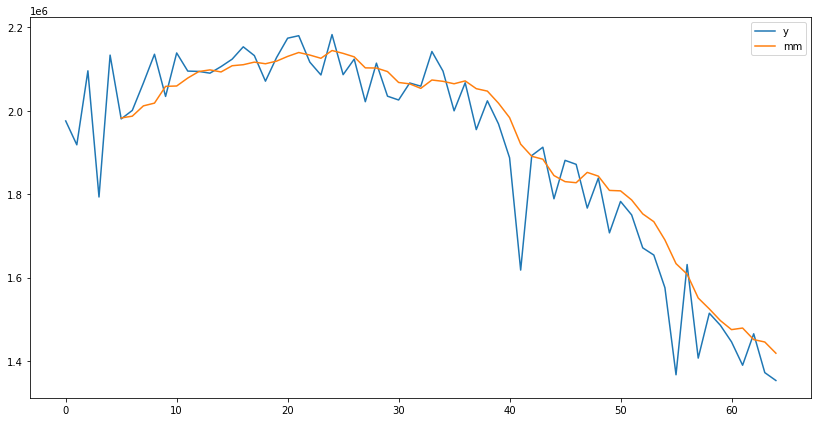

In [232]:
df_plot[['y', 'mm']].plot(figsize=(14, 7))

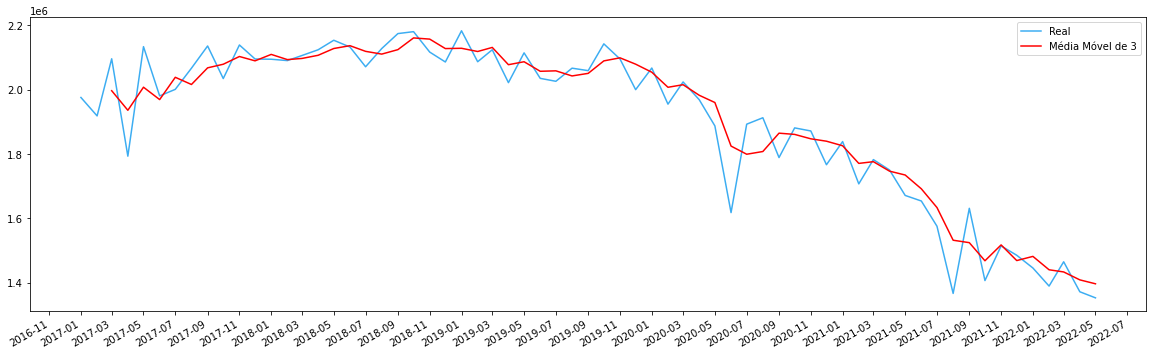

In [233]:
fig = plt.figure(figsize=(20, 6))

x = df_plot['ds']
y = df_plot['y']
mm3 = df_plot['y'].rolling(3).mean()
plt.plot(x, y, label='Real', color='#3CADF2')
plt.plot(x, mm3, label='Média Móvel de 3', color='red')

plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gcf().autofmt_xdate()

In [234]:
decompose = df[df['y'] > 0].set_index('ds')
decompose

,y
ds,
2017-01-01,1975685.45
2017-02-01,1918435.64
2017-03-01,2095963.00
2017-04-01,1793219.74
2017-05-01,2133632.30
...,...
2022-01-01,1445668.92
2022-02-01,1389495.49
2022-03-01,1464993.20


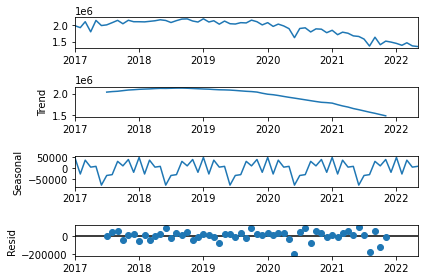

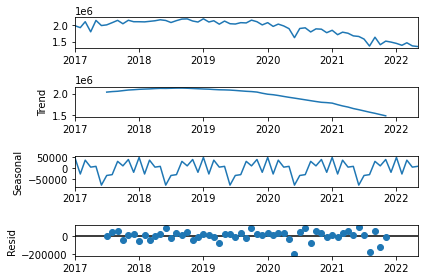

In [235]:
decompose_data = seasonal_decompose(decompose, model="additive")
decompose_data.plot()

<AxesSubplot:xlabel='ds'>

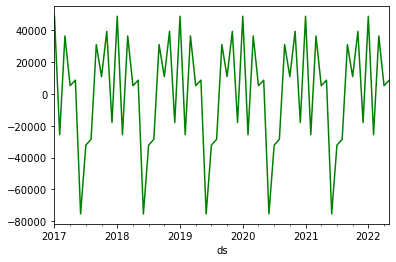

In [236]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [237]:
dftest = adfuller(decompose, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  1.259949604130465
2. P-Value :  0.9963750001078607
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 62
5. Critical Values :
	 1% :  -3.540522678829176
	 5% :  -2.9094272025108254
	 10% :  -2.5923136524453696


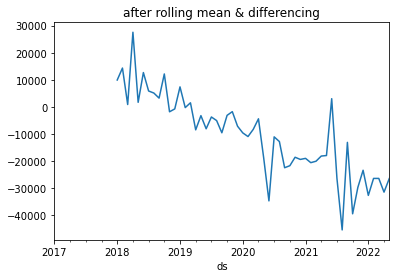

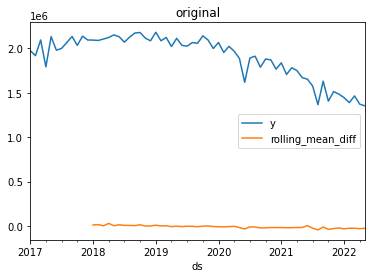

In [238]:
rolling_mean = decompose['y'].rolling(window = 12).mean()
decompose['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
decompose['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
decompose.plot(title='original');

In [239]:
dftest = adfuller(decompose['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -1.0763395337579742
2. P-Value :  0.7244146179372197
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 48
5. Critical Values :
	 1% :  -3.5745892596209488
	 5% :  -2.9239543084490744
	 10% :  -2.6000391840277777


In [240]:
temp = pd.DataFrame(pd.date_range(start='2022-06-01', periods=7, freq='M'), columns=['ds'])
temp['ds'] = pd.to_datetime(temp['ds'].dt.strftime('%Y-%m-01'))
temp['y'] = np.nan

df = pd.concat([df, temp]).reset_index(drop=True)
del temp
df

,ds,y
0,2017-01-01,1975685.45
1,2017-02-01,1918435.64
2,2017-03-01,2095963.00
3,2017-04-01,1793219.74
4,2017-05-01,2133632.30
...,...,...
67,2022-08-01,NaN
68,2022-09-01,NaN
69,2022-10-01,NaN
70,2022-11-01,NaN


In [241]:
dt_train_test = dt.datetime(2022, 1, 1)

xtrain = df[df['ds'] < dt_train_test]
xtest = df.loc[(df['ds'] >= dt_train_test) & (df['ds'] <= dt.datetime(2022, 12, 1))]

In [242]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_data = scaler.fit_transform(xtrain['y'].values.reshape(-1, 1))
xtrain['y'] = scaler_data

xtrain.head(3)

,ds,y
0,2017-01-01,0.746114
1,2017-02-01,0.675981
2,2017-03-01,0.893459


In [243]:
print('Train interval: ', xtrain['ds'].min().date(), ' até ', xtrain['ds'].max().date())

Train interval:  2017-01-01  até  2021-12-01


In [244]:
xtrain.tail(3)

,ds,y
57,2021-10-01,0.048975
58,2021-11-01,0.180982
59,2021-12-01,0.145288


In [245]:
print('Train interval: ', xtest['ds'].min().date(), ' até ', xtest['ds'].max().date())

Train interval:  2022-01-01  até  2022-12-01


In [246]:
xtest

,ds,y
60,2022-01-01,1445668.92
61,2022-02-01,1389495.49
62,2022-03-01,1464993.20
63,2022-04-01,1371781.80
64,2022-05-01,1352877.60
65,2022-06-01,NaN
66,2022-07-01,NaN
67,2022-08-01,NaN
68,2022-09-01,NaN
69,2022-10-01,NaN


In [247]:
interval_start = xtest.index.min()
interval_end = xtest.index.max()

print('Test interval: ', interval_start, ' até ', interval_end)

Test interval:  60  até  71


In [248]:
print('Train interval: ', xtrain['ds'].min().date(), ' até ', xtrain['ds'].max().date())
print('Test interval: ', xtest['ds'].min().date(), ' até ', xtest['ds'].max().date())

Train interval:  2017-01-01  até  2021-12-01
Test interval:  2022-01-01  até  2022-12-01


In [249]:
dt_train_test = dt.datetime(2022, 1, 1)

xtrain = df[df['ds'] < dt_train_test]
xtest = df[df['ds'] >= dt_train_test]

In [250]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_data = scaler.fit_transform(xtrain['y'].values.reshape(-1, 1))
xtrain['y'] = scaler_data

In [251]:
model = sm.tsa.statespace.SARIMAX(xtrain['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

In [252]:
xtest['pred'] = model_fit.predict(start=interval_start, end=interval_end, dynamic=True)

In [253]:
scaler_data = scaler.inverse_transform(xtest['pred'].values.reshape(-1, 1))
xtest['pred'] = scaler_data

In [254]:
xtest

,ds,y,pred
60,2022-01-01,1445668.92,1.497631e+06
61,2022-02-01,1389495.49,1.397176e+06
62,2022-03-01,1464993.20,1.461784e+06
63,2022-04-01,1371781.80,1.414314e+06
64,2022-05-01,1352877.60,1.362314e+06
65,2022-06-01,NaN,1.261402e+06
66,2022-07-01,NaN,1.297423e+06
67,2022-08-01,NaN,1.196376e+06
68,2022-09-01,NaN,1.306312e+06
69,2022-10-01,NaN,1.218048e+06


<AxesSubplot:>

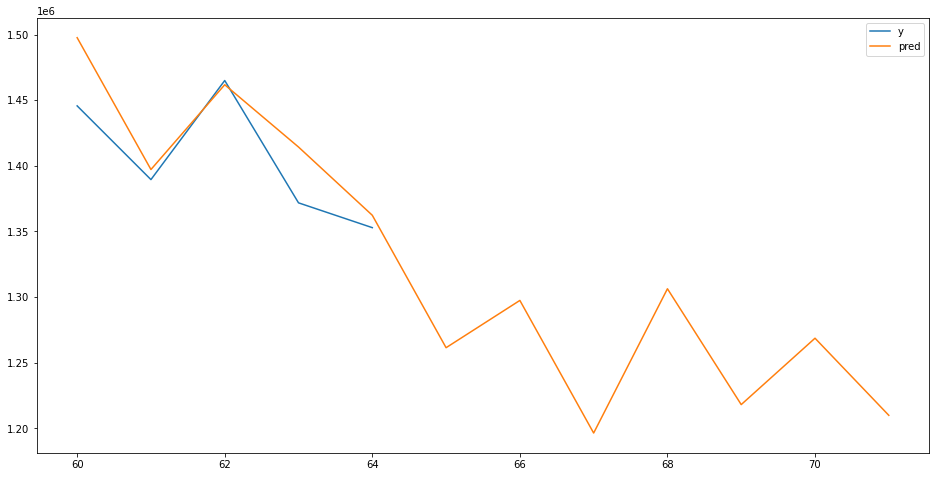

In [255]:
xtest[['y', 'pred']].plot(figsize=(16, 8))

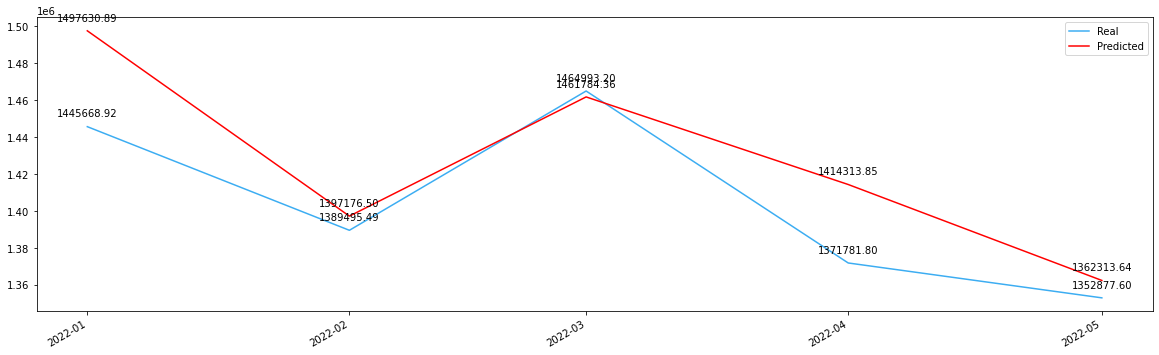

In [256]:
fig = plt.figure(figsize=(20, 6))

x = xtest[~xtest['y'].isna()]['ds']
y = xtest[~xtest['y'].isna()]['y']
p = xtest[~xtest['y'].isna()]['pred']
plt.plot(x, y, label='Real', color='#3CADF2')
plt.plot(x, p, label='Predicted', color='red')

for a, b in zip(x, y):
    plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

for a, b in zip(x, p):
    plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

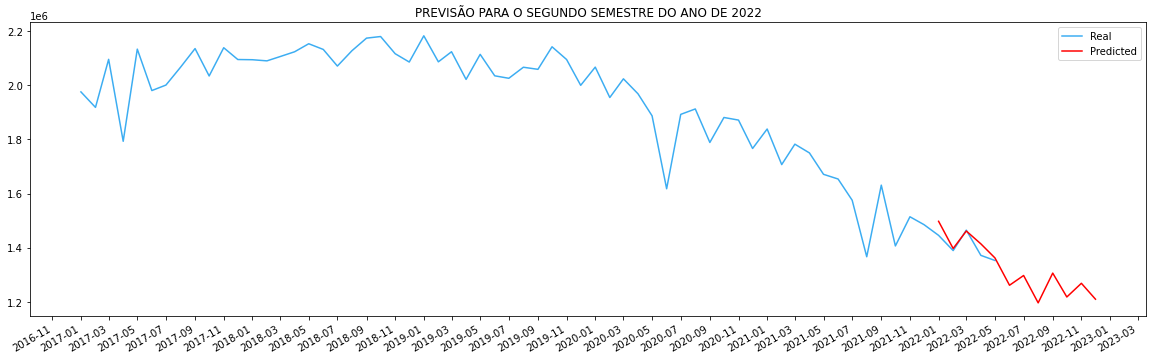

In [257]:
fig = plt.figure(figsize=(20, 6))

df_final = pd.concat([df[:interval_start], xtest])

x = df_final['ds'].dt.date
_real = df_final['y']
_pred = df_final['pred']

plt.plot(x, _real, label='Real', color='#3CADF2')
plt.plot(x, _pred, label='Predicted', color='red')
plt.legend()
plt.title("PREVISÃO PARA O SEGUNDO SEMESTRE DO ANO DE 2022")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gcf().autofmt_xdate()

Text(0.5, 1.0, 'Forecast de Faturamento do Controle - NEXT')

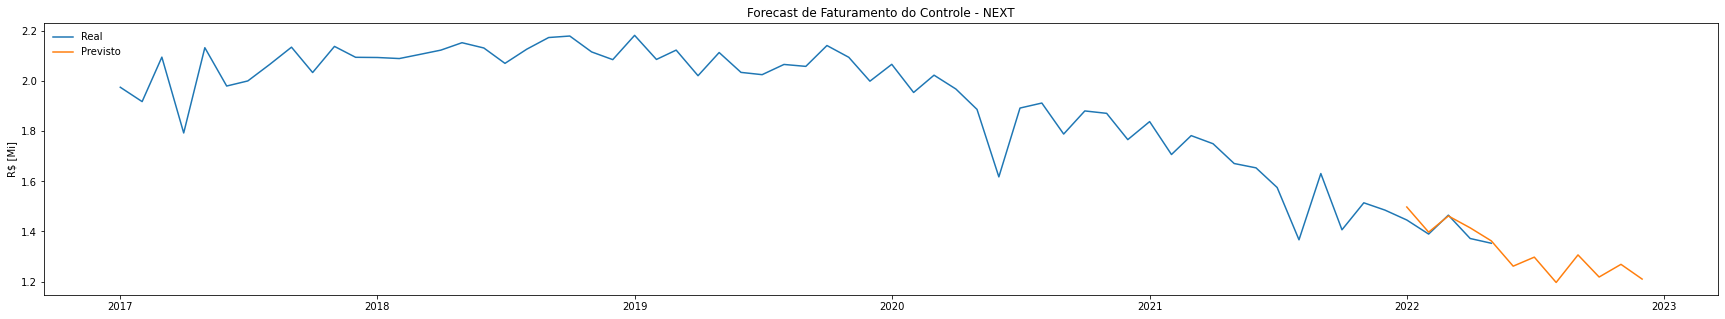

In [258]:
plt.figure(figsize=(30, 5))

ax = sns.lineplot(x=df_final['ds'], y=df_final.y.div(1e6), label="Real")
ax = sns.lineplot(x=df_final['ds'], y=df_final.pred.div(1e6), label="Previsto")

plt.legend()
leg = plt.legend(loc = 2, ncol = 1, shadow = False, fancybox = False, frameon = False, numpoints = 1)
leg.get_frame().set_alpha(0.5)

plt.xlabel("")
plt.ylabel("R$ [Mi]")
#plt.ylim([50,400])
plt.title("Forecast de Faturamento do Controle - NEXT")

In [259]:
y_true = xtest[~xtest['y'].isna()]['y'].values
y_pred = xtest[~xtest['y'].isna()]['pred'].values

In [260]:
# Mean Absolute Percentage Error & Root Mean Square Error
_mape = np.mean(np.abs((y_true - y_pred) / y_true )) * 100
_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print('MAPE: {:.2f}, MSE: {:.2f}'.format(_mape, _rmse))

MAPE: 1.63, MSE: 30552.76


In [261]:
_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('MSE: {:.2f}Mi'.format(_rmse/1E6))

MSE: 0.03Mi


In [268]:
from pandas.tseries.offsets import DateOffset
pred_date=[df.iloc[-1]['ds']+ DateOffset(months=x)for x in range(1,12)]
pred_date

[Timestamp('2023-01-01 00:00:00'),
 Timestamp('2023-02-01 00:00:00'),
 Timestamp('2023-03-01 00:00:00'),
 Timestamp('2023-04-01 00:00:00'),
 Timestamp('2023-05-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-09-01 00:00:00'),
 Timestamp('2023-10-01 00:00:00'),
 Timestamp('2023-11-01 00:00:00')]

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import math

In [15]:
df.set_index('ds', inplace=True)
df

,y
ds,
2017-01-01,1975685.45
2017-02-01,1918435.64
2017-03-01,2093317.00
2017-04-01,1792771.74
2017-05-01,2132525.30
...,...
2022-01-01,1445668.92
2022-02-01,1389495.49
2022-03-01,1464993.20


In [16]:
data = df.values
data = data.astype('float32')

In [25]:
train = data[0:60,:]
test = data[60:, :]    

In [26]:
def prepare_data(data, lags=1):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)  

In [27]:
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test    

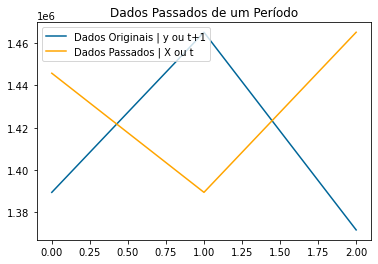

In [28]:
plt.plot(y_test, label='Dados Originais | y ou t+1', color='#006699')
plt.plot(X_test, label='Dados Passados | X ou t', color='orange')
plt.legend(loc='upper left')
plt.title('Dados Passados de um Período')
plt.show()

In [29]:
mdl = Sequential()
mdl.add(Dense(3, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
29/29 - 0s - loss: 4173321207808.0000 - 328ms/epoch - 11ms/step
Epoch 2/200
29/29 - 0s - loss: 3970190278656.0000 - 32ms/epoch - 1ms/step
Epoch 3/200
29/29 - 0s - loss: 3849848619008.0000 - 32ms/epoch - 1ms/step
Epoch 4/200
29/29 - 0s - loss: 3847942832128.0000 - 34ms/epoch - 1ms/step
Epoch 5/200
29/29 - 0s - loss: 3847941783552.0000 - 35ms/epoch - 1ms/step
Epoch 6/200
29/29 - 0s - loss: 3847942832128.0000 - 32ms/epoch - 1ms/step
Epoch 7/200
29/29 - 0s - loss: 3847942045696.0000 - 36ms/epoch - 1ms/step
Epoch 8/200
29/29 - 0s - loss: 3847941521408.0000 - 33ms/epoch - 1ms/step
Epoch 9/200
29/29 - 0s - loss: 3847941521408.0000 - 32ms/epoch - 1ms/step
Epoch 10/200
29/29 - 0s - loss: 3847941521408.0000 - 34ms/epoch - 1ms/step
Epoch 11/200
29/29 - 0s - loss: 3847941521408.0000 - 40ms/epoch - 1ms/step
Epoch 12/200
29/29 - 0s - loss: 3847941259264.0000 - 35ms/epoch - 1ms/step
Epoch 13/200
29/29 - 0s - loss: 3847941259264.0000 - 34ms/epoch - 1ms/step
Epoch 14/200
29/29 - 0s - loss: 

29/29 - 0s - loss: 3847930249216.0000 - 50ms/epoch - 2ms/step
Epoch 111/200
29/29 - 0s - loss: 3847930249216.0000 - 54ms/epoch - 2ms/step
Epoch 112/200
29/29 - 0s - loss: 3847930511360.0000 - 35ms/epoch - 1ms/step
Epoch 113/200
29/29 - 0s - loss: 3847929987072.0000 - 30ms/epoch - 1ms/step
Epoch 114/200
29/29 - 0s - loss: 3847929987072.0000 - 26ms/epoch - 899us/step
Epoch 115/200
29/29 - 0s - loss: 3847929987072.0000 - 34ms/epoch - 1ms/step
Epoch 116/200
29/29 - 0s - loss: 3847929724928.0000 - 42ms/epoch - 1ms/step
Epoch 117/200
29/29 - 0s - loss: 3847929462784.0000 - 35ms/epoch - 1ms/step
Epoch 118/200
29/29 - 0s - loss: 3847929462784.0000 - 33ms/epoch - 1ms/step
Epoch 119/200
29/29 - 0s - loss: 3847929462784.0000 - 31ms/epoch - 1ms/step
Epoch 120/200
29/29 - 0s - loss: 3847928938496.0000 - 30ms/epoch - 1ms/step
Epoch 121/200
29/29 - 0s - loss: 3847929200640.0000 - 30ms/epoch - 1ms/step
Epoch 122/200
29/29 - 0s - loss: 3847929200640.0000 - 30ms/epoch - 1ms/step
Epoch 123/200
29/29 - 0s

In [30]:
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Pontuação de Treino: 3847920549888.00 MSE (1961611.72 RMSE)
Pontuação de teste: 1986213183488.00 MSE (1409330.76 RMSE)


In [31]:
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

1/1 [==============================] - 0s 16ms/step


In [32]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

In [33]:
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-1, :] = test_predict

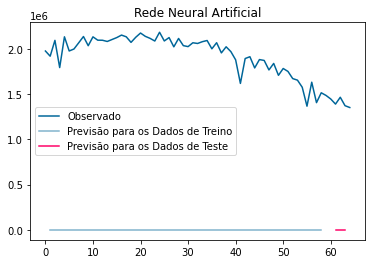

In [34]:
plt.plot(data, label='Observado', color='#006699');
plt.plot(train_predict_plot, label='Previsão para os Dados de Treino', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Previsão para os Dados de Teste', color='#ff0066');
plt.legend(loc='best');
plt.title('Rede Neural Artificial')
plt.show()

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import math

In [36]:
df

,y
ds,
2017-01-01,1975685.45
2017-02-01,1918435.64
2017-03-01,2093317.00
2017-04-01,1792771.74
2017-05-01,2132525.30
...,...
2022-01-01,1445668.92
2022-02-01,1389495.49
2022-03-01,1464993.20


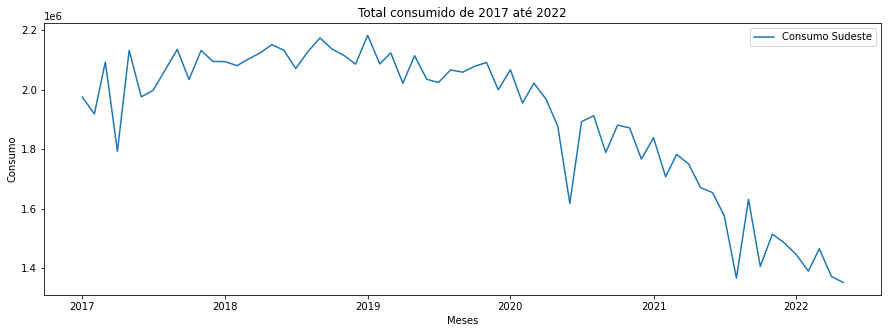

In [38]:
#visualizar
plt.figure(figsize=(15,5))
plt.plot(df, label='Consumo Sudeste')
plt.xlabel('Meses')
plt.ylabel('Consumo')
plt.title('Total consumido de 2017 até 2022')
plt.legend()
plt.show()

In [39]:
data_raw = df.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(data_raw)

In [42]:
len(dataset)

65

In [52]:
TRAIN_SIZE = 0.75
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset),:]
print('Numero de observações (dados de treino, dados de teste): ' + str((len(train),len(test))))

Numero de observações (dados de treino, dados de teste): (48, 17)


In [53]:
def create_dataset(dataset, window_size=1):
    data_X, data_Y = [],[]
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size),0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size,0])
    return(np.array(data_X), np.array(data_Y))

In [54]:
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print('Formato original dos dados de treino:')
print(train_X.shape)

train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))
print('Novo formato de treino:')
print(train_X.shape)

Formato original dos dados de treino:
(46, 1)
Novo formato de treino:
(46, 1, 1)


In [65]:
model = Sequential()
model.add(LSTM(16, input_shape = (1, window_size)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
46/46 - 1s - loss: 0.5102 - 1s/epoch - 23ms/step
Epoch 2/100
46/46 - 0s - loss: 0.2748 - 74ms/epoch - 2ms/step
Epoch 3/100
46/46 - 0s - loss: 0.1033 - 67ms/epoch - 1ms/step
Epoch 4/100
46/46 - 0s - loss: 0.0279 - 68ms/epoch - 1ms/step
Epoch 5/100
46/46 - 0s - loss: 0.0149 - 64ms/epoch - 1ms/step
Epoch 6/100
46/46 - 0s - loss: 0.0140 - 69ms/epoch - 1ms/step
Epoch 7/100
46/46 - 0s - loss: 0.0141 - 62ms/epoch - 1ms/step
Epoch 8/100
46/46 - 0s - loss: 0.0140 - 69ms/epoch - 2ms/step
Epoch 9/100
46/46 - 0s - loss: 0.0144 - 65ms/epoch - 1ms/step
Epoch 10/100
46/46 - 0s - loss: 0.0142 - 68ms/epoch - 1ms/step
Epoch 11/100
46/46 - 0s - loss: 0.0141 - 71ms/epoch - 2ms/step
Epoch 12/100
46/46 - 0s - loss: 0.0140 - 71ms/epoch - 2ms/step
Epoch 13/100
46/46 - 0s - loss: 0.0141 - 71ms/epoch - 2ms/step
Epoch 14/100
46/46 - 0s - loss: 0.0140 - 66ms/epoch - 1ms/step
Epoch 15/100
46/46 - 0s - loss: 0.0146 - 66ms/epoch - 1ms/step
Epoch 16/100
46/46 - 0s - loss: 0.0146 - 72ms/epoch - 2ms/step
Ep

In [66]:
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([train_Y])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([test_Y])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 17ms/step
Train Score: 97667.00 RMSE
Test Score: 270036.01 RMSE


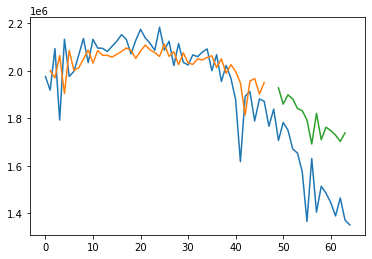

In [67]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

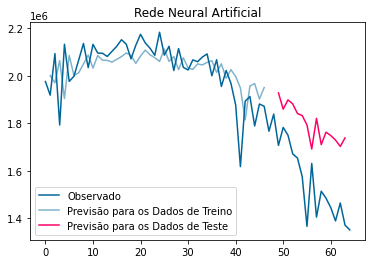

In [68]:
plt.plot(data, label='Observado', color='#006699');
plt.plot(trainPredictPlot, label='Previsão para os Dados de Treino', color='#006699', alpha=0.5);
plt.plot(testPredictPlot, label='Previsão para os Dados de Teste', color='#ff0066');
plt.legend(loc='best');
plt.title('Rede Neural Artificial')
plt.show()

In [69]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [70]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [71]:
window = 3
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

In [72]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [74]:
model = Sequential()
model.add(LSTM(16, input_shape=(1, window)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
39/39 - 1s - loss: 0.5771 - 1s/epoch - 34ms/step
Epoch 2/100
39/39 - 0s - loss: 0.2768 - 75ms/epoch - 2ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0911 - 76ms/epoch - 2ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0217 - 77ms/epoch - 2ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0124 - 70ms/epoch - 2ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0111 - 67ms/epoch - 2ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0113 - 65ms/epoch - 2ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0114 - 64ms/epoch - 2ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0116 - 71ms/epoch - 2ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0115 - 81ms/epoch - 2ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0112 - 78ms/epoch - 2ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0112 - 76ms/epoch - 2ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0112 - 75ms/epoch - 2ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0112 - 74ms/epoch - 2ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0114 - 73ms/epoch - 2ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0113 - 69ms/epoch - 2ms/step
Ep

In [75]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 18ms/step


In [76]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [77]:
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.10 RMSE
Test Score: 0.14 RMSE


In [79]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

In [80]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

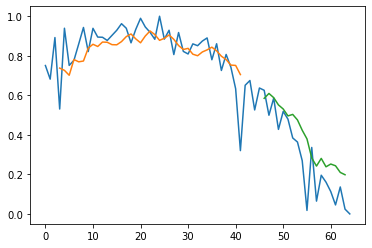

In [81]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

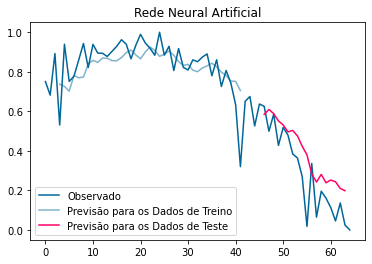

In [85]:
plt.plot(scaler.inverse_transform(dataset), label='Observado', color='#006699');
plt.plot(trainPredictPlot, label='Previsão para os Dados de Treino', color='#006699', alpha=0.5);
plt.plot(testPredictPlot, label='Previsão para os Dados de Teste', color='#ff0066');
plt.legend(loc='best');
plt.title('Rede Neural Artificial')
plt.show()

In [88]:
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [89]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [90]:
model = Sequential()
model.add(LSTM(16, input_shape=(window, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
39/39 - 1s - loss: 0.2396 - 1s/epoch - 31ms/step
Epoch 2/100
39/39 - 0s - loss: 0.0258 - 75ms/epoch - 2ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0113 - 107ms/epoch - 3ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0115 - 83ms/epoch - 2ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0118 - 81ms/epoch - 2ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0114 - 75ms/epoch - 2ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0114 - 76ms/epoch - 2ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0113 - 70ms/epoch - 2ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0118 - 71ms/epoch - 2ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0113 - 68ms/epoch - 2ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0119 - 70ms/epoch - 2ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0115 - 70ms/epoch - 2ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0112 - 70ms/epoch - 2ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0117 - 70ms/epoch - 2ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0117 - 71ms/epoch - 2ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0113 - 70ms/epoch - 2ms/step
E

In [91]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 23ms/step


In [92]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [93]:
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.11 RMSE
Test Score: 0.11 RMSE


In [95]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

In [96]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

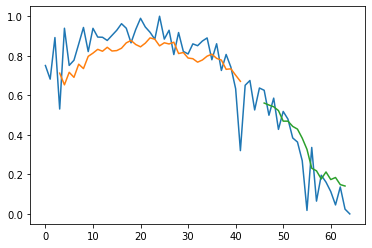

In [97]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

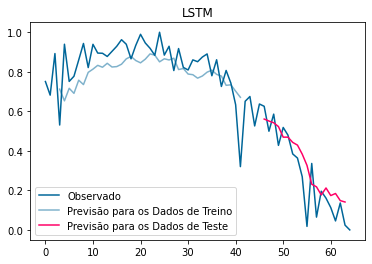

In [99]:
plt.plot(scaler.inverse_transform(dataset), label='Observado', color='#006699');
plt.plot(trainPredictPlot, label='Previsão para os Dados de Treino', color='#006699', alpha=0.5);
plt.plot(testPredictPlot, label='Previsão para os Dados de Teste', color='#ff0066');
plt.legend(loc='best');
plt.title('LSTM')
plt.show()